# Customer support chatbot with a small model

Below is an example of a customer support chatbot modeled as a state machine. It
is designed to work with smaller models by giving them context as to what part of
an interaction they are in, reducing the decision space a given LLM call has to keep
them focused.

The entrypoint is a node containing a chain that we have prompted to answer
basic questions, but delegate questions related to billing or technical support
to other "teams".

Depending on this entry node's response, the edge from that node will use an LLM
call to determine whether to respond directly to the user or invoke either the
`billing_support` or `technical_support` nodes.

- The technical support will attempt to answer the user's question with a more
  focused prompt.
- The billing agent can choose to answer the user's question, or can call out to a
  human for approval for a refund using a [dynamic breakpoint](https://langchain-ai.github.io/langgraphjs/how-tos/dynamic_breakpoints/).

![Diagram](./img/diagram.png)

This is intended as a sample, proof of concept architecture - you could extend
this example by giving individual nodes the ability to perform retrieval, other
tools, delegating to more powerful models at deeper stages etc.

Let's dive in!

## Setup

First we need to install the required packages. We'll use a relatively small model, Llama 3.1 8B hosted on [Together AI](https://www.together.ai/), to run the required inference.

```bash
yarn add @langchain/langgraph @langchain/community @langchain/core
```

You'll also need to set an environment variable named `TOGETHER_AI_API_KEY`, which you can obtain from your Together dashboard:

```ini
TOGETHER_AI_API_KEY="your_key_here"
```

## Initializing the model

First, we define the LLM we'll use for all calls and the LangGraph state.

In [1]:
import { ChatTogetherAI } from "@langchain/community/chat_models/togetherai";

const model = new ChatTogetherAI({
  model: "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
  temperature: 0,
});

## Laying out the graph

Now let's start defining logic for our nodes. Each node's return value will be added to
the graph state. We'll start with the prebuilt `MessagesAnnotation`, which is designed to
manage formatting and edge cases around messages returned from nodes:

```ts
{
  messages: BaseMessage[];
}
```

And we'll add two more state values: a string that defines the next representative,
and a boolean that will determine whether a human has authorized a refund
for a given thread. Our combined state will look like this:

```ts
{
  messages: BaseMessage[];
  nextRepresentative: string;
  refundAuthorized: boolean;
}
```

This state will be passed to the next executed node, or will be returned if execution has finished.
Definining the state looks like this:

In [2]:
import { Annotation, MessagesAnnotation } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  ...MessagesAnnotation.spec,
  nextRepresentative: Annotation<string>,
  refundAuthorized: Annotation<boolean>,
});

We will compute the `nextRepresentative` value within nodes to make resuming from given checkpoints fully deterministic - if we use an LLM within an edge, resuming from a given state will have some undesirable randomness.

Now, let's define our entrypoint node. This will be modeled after a secretary who can
handle incoming questions and respond conversationally or route to a more specialized team:

In [3]:
import { z } from "zod";
import { zodToJsonSchema } from "zod-to-json-schema";

const initialSupport = async (state: typeof StateAnnotation.State) => {
  const SYSTEM_TEMPLATE =
    `You are frontline support staff for LangCorp, a company that sells computers.
Be concise in your responses.
You can chat with customers and help them with basic questions, but if the customer is having a billing or technical problem,
do not try to answer the question directly or gather information.
Instead, immediately transfer them to the billing or technical team by asking the user to hold for a moment.
Otherwise, just respond conversationally.`;
  const supportResponse = await model.invoke([
    { role: "system", content: SYSTEM_TEMPLATE },
    ...state.messages,
  ]);

  const CATEGORIZATION_SYSTEM_TEMPLATE = `You are an expert customer support routing system.
Your job is to detect whether a customer support representative is routing a user to a billing team or a technical team, or if they are just responding conversationally.`;
  const CATEGORIZATION_HUMAN_TEMPLATE =
    `The previous conversation is an interaction between a customer support representative and a user.
Extract whether the representative is routing the user to a billing or technical team, or whether they are just responding conversationally.
Respond with a JSON object containing a single key called "nextRepresentative" with one of the following values:

If they want to route the user to the billing team, respond only with the word "BILLING".
If they want to route the user to the technical team, respond only with the word "TECHNICAL".
Otherwise, respond only with the word "RESPOND".`;
  const categorizationResponse = await model.invoke([{
    role: "system",
    content: CATEGORIZATION_SYSTEM_TEMPLATE,
  },
  ...state.messages,
  {
    role: "user",
    content: CATEGORIZATION_HUMAN_TEMPLATE,
  }],
  {
    response_format: {
      type: "json_object",
      schema: zodToJsonSchema(
        z.object({
          nextRepresentative: z.enum(["BILLING", "TECHNICAL", "RESPOND"]),
        })
      )
    }
  });
  // Some chat models can return complex content, but Together will not
  const categorizationOutput = JSON.parse(categorizationResponse.content as string);
  // Will append the response message to the current interaction state
  return { messages: [supportResponse], nextRepresentative: categorizationOutput.nextRepresentative };
};

We use Together AI's JSON mode above to guarantee parseable output when deciding the next representative.

Next, our nodes representing billing and technical support. We give special
instructions in the billing prompt that it can choose to authorize refunds by
routing to another agent:

In [5]:
const billingSupport = async (state: typeof StateAnnotation.State) => {
  const SYSTEM_TEMPLATE =
    `You are an expert billing support specialist for LangCorp, a company that sells computers.
Help the user to the best of your ability, but be concise in your responses.
You have the ability to authorize refunds, which you can do by transferring the user to another agent who will collect the required information.
If you do, assume the other agent has all necessary information about the customer and their order.
You do not need to ask the user for more information.

Help the user to the best of your ability, but be concise in your responses.`;

  let trimmedHistory = state.messages;
  // Make the user's question the most recent message in the history.
  // This helps small models stay focused.
  if (trimmedHistory[trimmedHistory.length - 1].getType() === "ai") {
    trimmedHistory = trimmedHistory.slice(0, -1);
  }

  const billingRepResponse = await model.invoke([
    {
      role: "system",
      content: SYSTEM_TEMPLATE,
    },
    ...trimmedHistory,
  ]);
  const CATEGORIZATION_SYSTEM_TEMPLATE =
    `Your job is to detect whether a billing support representative wants to refund the user.`;
  const CATEGORIZATION_HUMAN_TEMPLATE =
    `The following text is a response from a customer support representative.
Extract whether they want to refund the user or not.
Respond with a JSON object containing a single key called "nextRepresentative" with one of the following values:

If they want to refund the user, respond only with the word "REFUND".
Otherwise, respond only with the word "RESPOND".

Here is the text:

<text>
${billingRepResponse.content}
</text>.`;
  const categorizationResponse = await model.invoke([
    {
      role: "system",
      content: CATEGORIZATION_SYSTEM_TEMPLATE,
    },
    {
      role: "user",
      content: CATEGORIZATION_HUMAN_TEMPLATE,
    }
  ], {
    response_format: {
      type: "json_object",
      schema: zodToJsonSchema(
        z.object({
          nextRepresentative: z.enum(["REFUND", "RESPOND"]),
        })
      )
    }
  });
  const categorizationOutput = JSON.parse(categorizationResponse.content as string);
  return {
    messages: billingRepResponse,
    nextRepresentative: categorizationOutput.nextRepresentative,
  };
};

const technicalSupport = async (state: typeof StateAnnotation.State) => {
  const SYSTEM_TEMPLATE =
    `You are an expert at diagnosing technical computer issues. You work for a company called LangCorp that sells computers.
Help the user to the best of your ability, but be concise in your responses.`;

  let trimmedHistory = state.messages;
  // Make the user's question the most recent message in the history.
  // This helps small models stay focused.
  if (trimmedHistory[trimmedHistory.length - 1].getType() === "ai") {
    trimmedHistory = trimmedHistory.slice(0, -1);
  }

  const response = await model.invoke([
    {
      role: "system",
      content: SYSTEM_TEMPLATE,
    },
    ...trimmedHistory,
  ]);

  return {
    messages: response,
  };
};

Finally, a node that will handle refunds. The logic is stubbed out here since
it's not a real system, but in practice you could add a real tool here requiring human
approval. We use a special error called a `NodeInterrupt` in order to allow for resumption
of the graph later, after a human has examined the state and confirmed that a refund is suitable:

In [6]:
import { NodeInterrupt } from "@langchain/langgraph";

const handleRefund = async (state: typeof StateAnnotation.State) => {
  if (!state.refundAuthorized) {
    console.log("--- HUMAN AUTHORIZATION REQUIRED FOR REFUND ---");
    throw new NodeInterrupt("Human authorization required.")
  }
  return {
    messages: {
      role: "assistant",
      content: "Refund processed!",
    },
  };
};

We can start building our graph out now by adding all of the above functions as nodes and setting `initial_support` as our starting node:

In [7]:
import { StateGraph } from "@langchain/langgraph";

let builder = new StateGraph(StateAnnotation)
  .addNode("initial_support", initialSupport)
  .addNode("billing_support", billingSupport)
  .addNode("technical_support", technicalSupport)
  .addNode("handle_refund", handleRefund)
  .addEdge("__start__", "initial_support");

## Connecting the nodes

Great! Now let's move onto the edges. These edges will evaluate the current
state of the graph created by the return values of the individual nodes and
route execution accordingly.

First, we want our `initial_support` node to either delegate to the billing
node, technical node, or just respond directly to the user. Here's one example
of how we might do that:

In [8]:
builder = builder.addConditionalEdges("initial_support", async (state: typeof StateAnnotation.State) => {
  if (state.nextRepresentative.includes("BILLING")) {
    return "billing";
  } else if (state.nextRepresentative.includes("TECHNICAL")) {
    return "technical";
  } else {
    return "conversational";
  }
}, {
  billing: "billing_support",
  technical: "technical_support",
  conversational: "__end__",
});

console.log("Added edges!");

Added edges!


**Note:** We do not use tool calling here for formatting the next step from
the history because our model does not support it, but you can apply it here if
your model does.

Let's continue. We add an edge making the technical support node always end,
since it has no tools to call. The billing support node uses a conditional edge
since it can either call the refund tool or end.

In [9]:
builder = builder
  .addEdge("technical_support", "__end__")
  .addConditionalEdges("billing_support", async (state: typeof StateAnnotation.State) => {
    if (state.nextRepresentative.includes("REFUND")) {
      return "refund";
    } else {
      return "__end__";
    }
  }, {
    refund: "handle_refund",
    __end__: "__end__",
  })
  .addEdge("handle_refund", "__end__");

console.log("Added edges!");

Added edges!


Let's finalize our graph by calling `.compile()`. We'll also use an in-memory checkpointer to store state:

In [10]:
import { MemorySaver } from "@langchain/langgraph";

const checkpointer = new MemorySaver();

const graph = builder.compile({
  checkpointer,
});

Here's a representation of the currently constructed graph:

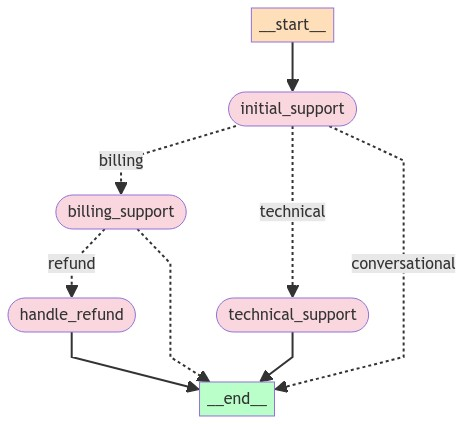

In [11]:
import * as tslab from "tslab";

const representation = graph.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

And now let's test it!

We can get the returned value from the executed nodes as they are generated
using the `.stream()` runnable method (we also could go even more granular and
get output as it is generated using `.streamEvents()`, but this requires a bit
more parsing).

Here's an example with a billing related refund query. Because of how we defined our state, the input must be a message (or a list of messages) representing the user's question:

In [12]:
const stream = await graph.stream({
  messages: [
    {
      role: "user",
      content: "I've changed my mind and I want a refund for order #182818!",
    }
  ]
}, {
  configurable: {
    thread_id: "refund_testing_id",
  }
});

for await (const value of stream) {
  console.log("---STEP---");
  console.log(value);
  console.log("---END STEP---");
}

---STEP---
{
  initial_support: {
    messages: AIMessage {
      "id": "8beb633a396c67fd-SJC",
      "content": "I'd be happy to help you with that. However, I need to check on our refund policy for you. Can you please hold for just a moment while I transfer you to our billing team? They'll be able to assist you with the refund process.",
      "additional_kwargs": {},
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 53,
          "promptTokens": 116,
          "totalTokens": 169
        },
        "finish_reason": "eos"
      },
      "tool_calls": [],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 116,
        "output_tokens": 53,
        "total_tokens": 169
      }
    },
    nextRepresentative: 'BILLING'
  }
}
---END STEP---
---STEP---
{
  billing_support: {
    messages: AIMessage {
      "id": "8beb634908a12500-SJC",
      "content": "I'd be happy to assist you with a refund. I'll transfer you to our Refunds Te

[This LangSmith trace](https://smith.langchain.com/public/86af9fe3-452e-4249-abec-7ddc0752a704/r) illustrates that execution goes to `billing_support`, but then hits our dynamic interrupt because `refundAuthorized` is not set in the graph state. We can see this by inspecting the current state of the graph and noting that there is an interrupt when running `handle_refund`:

In [13]:
const currentState = await graph.getState({ configurable: { thread_id: "refund_testing_id" } });

console.log("CURRENT TASKS", JSON.stringify(currentState.tasks, null, 2));

CURRENT TASKS [
  {
    "id": "5ab19c8b-c947-5bf7-a3aa-4edae60c1a96",
    "name": "handle_refund",
    "interrupts": [
      {
        "value": "Human authorization required.",
        "when": "during"
      }
    ]
  }
]


We can also see that the next tasks if we were to resume execution would be `handle_refund` again:

In [14]:
console.log("NEXT TASKS", currentState.next);

NEXT TASKS [ 'handle_refund' ]


But this will again hit the interrupt because `refundAuthorized` is not set. If we update the state to set `refundAuthorized` to true, then resume the graph by running it with the same `thread_id` and passing `null` as the input, execution will continue and the refund will process:

In [15]:
await graph.updateState({ configurable: { thread_id: "refund_testing_id" } }, {
  refundAuthorized: true,
});

const resumedStream = await graph.stream(null, { configurable: { thread_id: "refund_testing_id" }});

for await (const value of resumedStream) {
  console.log(value);
}

{
  handle_refund: { messages: { role: 'assistant', content: 'Refund processed!' } }
}


[Click here to see a LangSmith trace of the above run](https://smith.langchain.com/public/1c626e0f-5827-47c3-aadb-ec571dd37eb5/r)

Now, let's try a technical question:

In [16]:
const technicalStream = await graph.stream({
  messages: [{
    role: "user",
    content: "My LangCorp computer isn't turning on because I dropped it in water.",
  }]
}, {
  configurable: {
    thread_id: "technical_testing_id"
  }
});

for await (const value of technicalStream) {
  console.log(value);
}

{
  initial_support: {
    messages: AIMessage {
      "id": "8beb66886c0c15d8-SJC",
      "content": "Oh no, sorry to hear that! Water damage can be a real challenge. Have you tried unplugging it and letting it dry out for a bit? Sometimes, it's just a matter of giving it some time to recover.",
      "additional_kwargs": {},
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 47,
          "promptTokens": 115,
          "totalTokens": 162
        },
        "finish_reason": "eos"
      },
      "tool_calls": [],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 115,
        "output_tokens": 47,
        "total_tokens": 162
      }
    },
    nextRepresentative: 'TECHNICAL'
  }
}
{
  technical_support: {
    messages: AIMessage {
      "id": "8beb66986df91701-SJC",
      "content": "Sorry to hear that. Water damage can be a real challenge. Let's try to troubleshoot the issue.\n\nCan you tell me:\n\n1. How long was the compu

[Click here to see a LangSmith trace of the above run](https://smith.langchain.com/public/d131f6ea-e8d6-41f2-addd-fd9b55c6e057/r)

We can see the query gets correctly routed to the technical support node!

Finally, let's try a simple conversational response:

In [17]:
const conversationalStream = await graph.stream({
  messages: [{
    role: "user",
    content: "How are you? I'm Cobb."
  }]
}, {
  configurable: {
    thread_id: "conversational_testing_id"
  }
});

for await (const value of conversationalStream) {
  console.log(value);
}

{
  initial_support: {
    messages: AIMessage {
      "id": "8beb6712294915e3-SJC",
      "content": "Hi Cobb! I'm doing great, thanks for asking. How can I help you today? Are you looking to purchase a new computer or just have a question about our products?",
      "additional_kwargs": {},
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 37,
          "promptTokens": 108,
          "totalTokens": 145
        },
        "finish_reason": "eos"
      },
      "tool_calls": [],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 108,
        "output_tokens": 37,
        "total_tokens": 145
      }
    },
    nextRepresentative: 'RESPOND'
  }
}


And we can see that the `initial_support` node handles it by itself, with no routing to technical or billing support.

[Click here to see a LangSmith trace of the above run](https://smith.langchain.com/public/4cf5ff90-b9c6-4628-989f-28cb0c4910db/r)

## Further reading

You may have noticed that the response from each node adds a message to the history in the state, and that as a result we end up with multiple assistant messages in a row corresponding to the different customer support personas the LLM takes on.

With `MessagesAnnotation`, it is possible to trim this state by returning a **message modifier** containing the same `id` as the message you want to remove. [See this guide](/langgraphjs/how-tos/delete-messages/) for more.